In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
#given inputs
temp = 298 #kelvin
pres = 1e5 #Pascals
Rgas = 8.314 #J/(mol-K)
avo = 6.022e23 

nox = 30 #ppbv
rh = 100 #ppbv 
PHOx = 0.1 #pptv/s

In [3]:
#rate constants, units are cm3/(molec-s)
k1 = 26.3e-12
k2 = 7.7e-12
k3 = 8.1e-12
k4 = 1.1e-11
k5 = 2.9e-12
k6 = 5.2e-12
k7 = 0.015 # units s-1
k8 = 1.9e-14


In [4]:
#unit conversions
airden = (pres*avo) / (Rgas*temp*1e6) #molec/cm3
Cnox = nox*1e-9*airden
Crh = rh*1e-9*airden
CPHOx = PHOx*1e-12*airden  #molec/(cm3-s)
ppbfac = 1e9/airden

In [5]:
# u[0] u[1] u[2] u[3] u[4] u[5] u[6]
# NO   NO2   OH  RO2  HO2   O3   RH
def myfun(t,u):
    f = np.zeros(7)
    f[0] = -k2*u[3]*u[0] + k7*u[1] - k8*u[5]*u[0] - k3*u[4]*u[0]
    f[1] = k2*u[3]*u[0] + k3*u[4]*u[0] + k8*u[5]*u[0] - k7*u[1] - k4*u[2]*u[1]
    f[2] = -k1*u[6]*u[2] + k3*u[4]*u[0] - k4*u[2]*u[1] + CPHOx 
    f[3] = k1*u[6]*u[2] - k2*u[3]*u[0] - k6*u[3]*u[4]
    f[4] = k2*u[3]*u[0] - k3*u[4]*u[0] - 2*k5*u[4]**2 - k6*u[3]*u[4]
    f[5] = k7*u[1] - k8*u[5]*u[0]
    f[6] = -k1*u[6]*u[2]
    return f

In [6]:
#initial conditions
# NOx = NO + NO2
u0 = np.zeros(7)
u0[0] = Cnox*(2/3)
u0[1] = Cnox*(1/3)
u0[2] = 0
u0[3] = 0
u0[4] = 0
u0[5] = 0
u0[6] = Crh   #molec / cm3 of RH hydrocarbon


In [7]:
#timestep
Dt = 2 #seconds
t0 = 0
tmax = 96*3600
t = np.arange(t0, t0+tmax, Dt)
NN = np.shape(t)
N = NN[0]

In [8]:
sol = solve_ivp(myfun, [t0,tmax], u0, method='LSODA', t_eval=t)

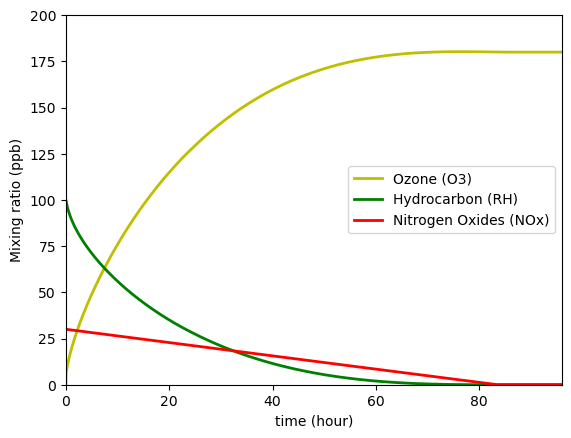

In [9]:
fig1 = plt.figure()
ax1 = plt.subplot(111)
plt.axis( [0, tmax/3600, 0, 200] )
plt.plot( sol.t/3600, sol.y[5]*ppbfac, 'y-', lw=2, label='Ozone (O3)')
plt.plot( sol.t/3600, sol.y[6]*ppbfac, 'g-', lw=2, label='Hydrocarbon (RH)')
plt.plot( sol.t/3600, (sol.y[0] + sol.y[1])*ppbfac, 
         'r-', lw=2, label='Nitrogen Oxides (NOx)')
plt.xlabel('time (hour)')
plt.ylabel('Mixing ratio (ppb)')
plt.legend()



In [10]:
maxO3 = np.max(sol.y[5]*ppbfac)
maxO3

180.23085914001217

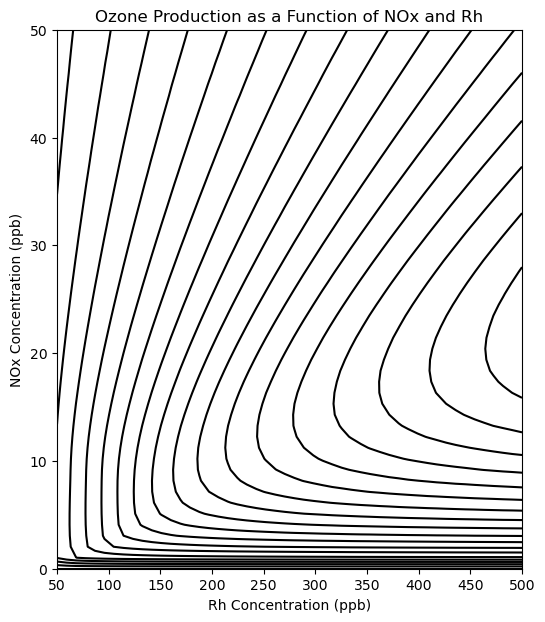

In [58]:
tStep = 50;
noxRange = np.linspace(0, 50, tStep)
rhRange = np.linspace(50, 500, tStep)
O3out = np.zeros((len(rhRange), len(noxRange)))
#print(NOxIn, RhIn, t)

# put above into function and get values into new array
for i, rh in enumerate(rhRange):
    for j, nox in enumerate(noxRange):
        u0[0] = nox*1e-9*airden*(2/3)
        u0[1] = nox*1e-9*airden*(1/3)
        u0[6] = rh*1e-9*airden

        sol = solve_ivp(myfun, [t0,tmax], u0, method='LSODA', t_eval=t)
        O3out[i,j] = sol.y[5, -1]*ppbfac

plt.figure(figsize=(7, 7))
contour = plt.contour(rhRange, noxRange, O3out.T, levels=20, colors='black')  # Transpose to match axes

# Add a colorbar
#cbar = plt.colorbar(contour)
#cbar.set_label('Ozone (ppb)')

# Add labels and title
plt.xlabel('Initial Rh(ppb)')
plt.ylabel('Initial NOx (ppb)')
plt.title('Ozone Production as a Function of NOx and Rh')

# Show the plot
plt.show()